## **Project 8 - Introduction to Computer Vision**

### **Title**: *Plants Seedling Classification*

### **Author**: *Pankaj Singh*

<br>

**Domain** 

Image Classification

**Project Context**

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term.

The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has provided the data containing images of unique plants belonging to 12 different species. You being a data scientist, need to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

**Data Description** 

This dataset contains images of unique plants belonging to 12 different species.
The data file names are:
- images.npy
- Label.csv

List of Plant species in label.csv
- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

**Project Deliverables**

The goal of the project is to create a classifier capable of determining a plant's species from an image.

**Learning Objective**

- Explore and visualize the dataset.
- Data preprocessing
- Neural Network implementation on dataset
- Generate a set of insights and recommendations that will help the bank

## **Import Libraries**

In [73]:
import pandas as pd
import numpy as np
import warnings
import random

## Import Scikit Learn functionalities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

## Import Tensorflow functionalities
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import backend
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50

## Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from google.colab.patches import cv2_imshow 

random.seed(1)
np.random.seed(1) 
tf.random.set_seed(1)
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Reading the dataset**

In [74]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/Colab Notebooks/PGPAIML/IntrotoCV/Project/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PGPAIML/IntrotoCV/Project/Labels.csv')

## **Overview of the dataset**


Let's print the shape of the images and labels 

In [75]:
## Print the shape of images dataset in order: # of images, # of pixels in x direction, # of pixels in y direction and # of color channels
print('Image dataset shape =',images.shape)
## Print the shape of size of labels dataset
print('Image label shape =',labels.shape)

Image dataset shape = (4750, 128, 128, 3)
Image label shape = (4750, 1)


There are 4750 RGB  images of shape 128 x 128 X 3, each image having 3 channels.

### **Plotting images using OpenCV and matplotlib**

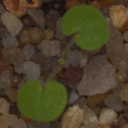

In [76]:
## Check the image using openCV
cv2_imshow(images[5])

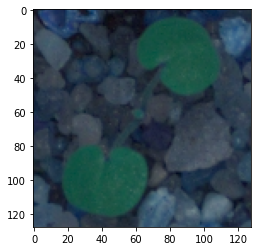

In [77]:
## Check the image using matplotlib
plt.imshow(images[5])

- We can observe that the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.
- Now we will convert these BGR images to RGB images so we could interpret them easily.

In [78]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

## **Exploratory Data Analysis** 

- ### **Get a peek at the images corresponding to all unique labels**

In [79]:
def plot_images(images,labels):
  categories=np.unique(labels)   # Number of Classes
  num_classes=len(categories)    # Obtain the unique classes from y_train                               
  keys=dict(labels['Label'])                   
  rows = 3                       # Defining number of rows=3
  cols = 4                       # Defining number of columns=4
  fig = plt.figure(figsize=(20, 16)) # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = random.choice(labels[labels['Label'] == categories[i * rows + j]].index.values)
                                                                                  # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image 
          ax.set_title(keys[random_index])
  plt.show()

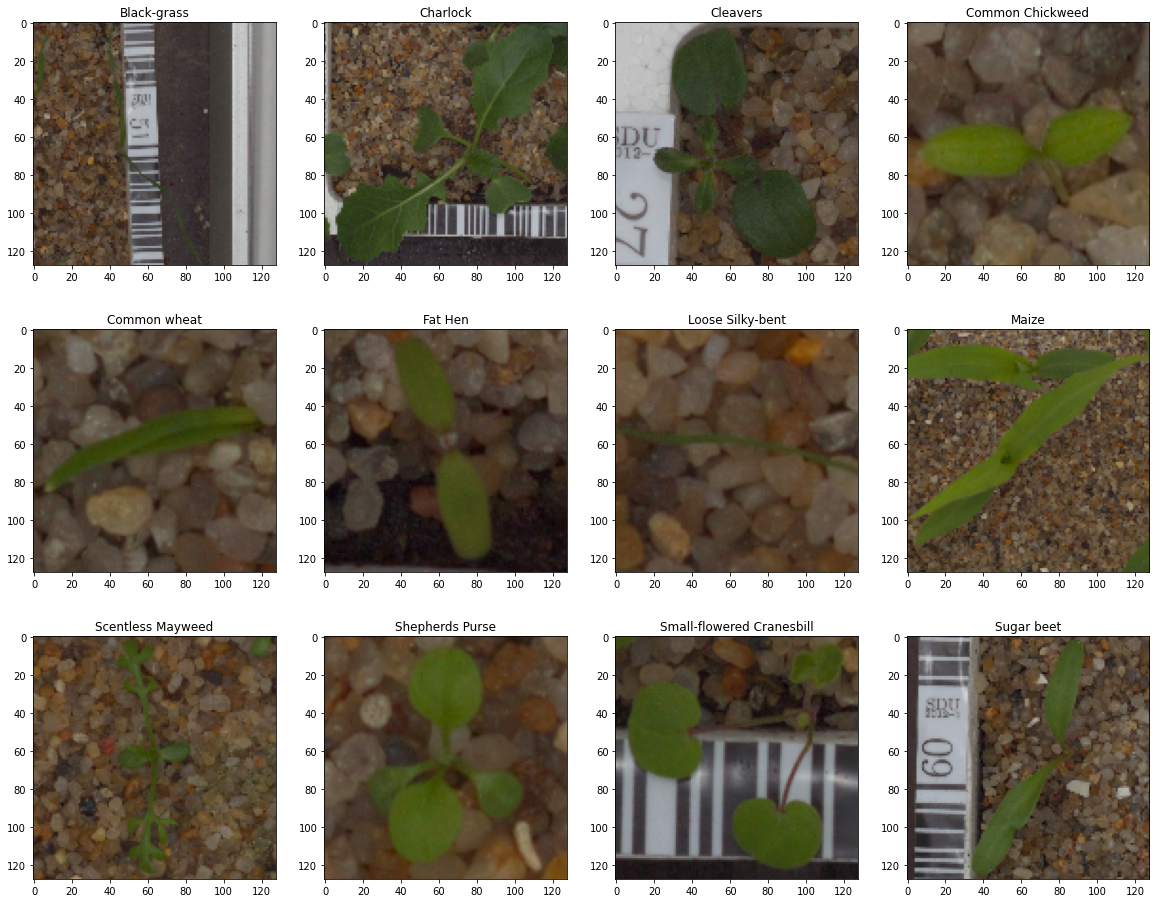

In [80]:
plot_images(images,labels)

- As we can see that there are two problematic species which will be hard to identify even by human eyes and would be much harder for computer vision algorithm due to the size of leaves,
1. Black-grass
2. Loose Silky-bent

- ### **Checking for data imbalance**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

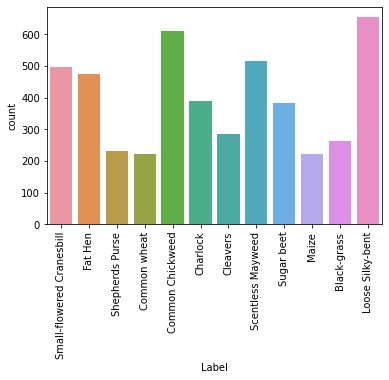

In [81]:
 ## Show the countplot of all the species in the dataset
 sns.countplot(labels['Label'])
 plt.xticks(rotation='vertical')

- As you can see from the above plot, the dataset is not balanced.

- ### **Resizing images**

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [82]:
## Reduce the size of the images from 128x128 to 64x64
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

- ### **Visualizing images using Gaussian Blur**

In [83]:
# Applying Gaussian Blur to denoise the images
images_gb=[]
for i in range(len(images_decreased)):
  images_gb.append(cv2.GaussianBlur(images_decreased[i], ksize =(3,3),sigmaX = 0))

Text(0.5, 1.0, 'With Gaussian Blur')

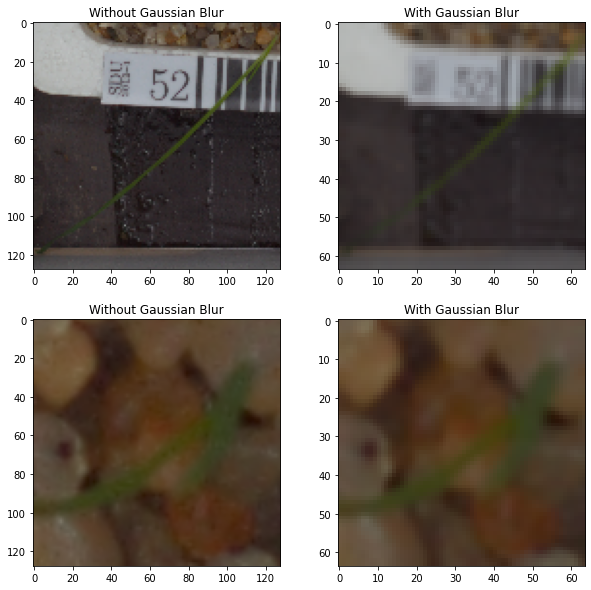

In [84]:
## Let's check two images from the two problematic species
fig = plt.figure(figsize=(10, 10))

## Show the image of Black-grass with and without Gaussian Blur
idx1 = random.choice(labels[labels['Label'] == 'Black-grass'].index.values)
ax1 = fig.add_subplot(2, 2, 1)
ax1.imshow(images[idx1])                      
ax1.set_title('Without Gaussian Blur')
ax2 = fig.add_subplot(2, 2, 2)
ax2.imshow(images_gb[idx1])        
ax2.set_title('With Gaussian Blur')

## Show the image of Loose Silky-bent with and without Gaussian Blur
idx2 = random.choice(labels[labels['Label'] == 'Loose Silky-bent'].index.values)
ax3 = fig.add_subplot(2, 2, 3)
ax3.imshow(images[idx2])                      
ax3.set_title('Without Gaussian Blur')
ax4 = fig.add_subplot(2, 2, 4)
ax4.imshow(images_gb[idx2])        
ax4.set_title('With Gaussian Blur')

- It appears that GaussianBlur would be ineffective because the blurred or denoised image does not seem to contain any relevant information, and the model would struggle to categorize these blurred images.

- ### **Observations**:

- There are 4750 images in the dataset and they belong to 12 different species of seedling

- The original dataset is in BGR format and we mapped it to RGB format

- The data set is imbalanced

- The dataset contains two species which are problematic in identification even to a human eye,
  1. Black-grass
  2. Loose Silky-bent
  - These two species have very thin leaves and in some cases it is diffcult to spot them against the background

## **Data pre-processing**

- ### **Splitting the dataset**

- As we have less images in our dataset, we will only use 10% of our data for testing, 10% of our data for validation and 80% of our data for training.
- We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.


In [88]:
X_train, X_temp, y_train, y_temp = train_test_split(np.array(images_gb),labels , test_size=0.2, random_state=42, stratify=labels)
X_test , X_val , y_test , y_val = train_test_split(X_temp              ,y_temp , test_size=0.5, random_state=42, stratify=y_temp)

- ### **Encoding the target labels**

In [89]:
enc = LabelBinarizer()
## Fit and transform the encoder on the train label data
y_train_encoded = enc.fit_transform(y_train)
## Transform the validation data
y_val_encoded=enc.transform(y_val)
## Transform the test data
y_test_encoded=enc.transform(y_test)

- ### **Data Normalization**

Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [90]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

- ### **Check the sizes of the datasets created**



In [91]:
print('Test dataset shape')
print('Feature dataset :', X_train.shape, ', Target dataset :', y_train_encoded.shape)
print()
print('Train dataset shape')
print('Feature dataset :',X_test.shape, ', Target dataset :', y_test_encoded.shape)
print()
print('Validation dataset shape')
print('Feature dataset :',X_val.shape, ', Target dataset :', y_val_encoded.shape)

Test dataset shape
Feature dataset : (3800, 64, 64, 3) , Target dataset : (3800, 12)

Train dataset shape
Feature dataset : (475, 64, 64, 3) , Target dataset : (475, 12)

Validation dataset shape
Feature dataset : (475, 64, 64, 3) , Target dataset : (475, 12)


## **Model Building**

- ### **Useful functions for model development and evaluations**

- #### **Confusion Matrix**

In [100]:
def make_confusion_matrix(model, X, Y, 
                          axis,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=False,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''

    # Here we would get the output as probablities for each category
    y_pred=model.predict(X)

    
    # Obtaining the categorical values from y_val_encoded and y_pred
    y_pred_arg=np.argmax(y_pred,axis=1)
    y_val_arg=np.argmax(Y,axis=1)

    # Extract the name of categories from the encoder
    categories = enc.inverse_transform(np.eye(12))

    # Print out the classification Report
    print('#------------------------------------------------#')
    print(classification_report(y_val_arg, y_pred_arg,target_names=categories))
    print('#------------------------------------------------#')
    
    # Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
    cf = tf.math.confusion_matrix(y_val_arg,y_pred_arg).numpy()

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))



    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    
    
    # MAKE THE HEATMAP VISUALIZATION
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories, ax=axis)
    axis.set_xlabel('Predicted', fontsize=15)
    axis.set_ylabel('Actual', fontsize=15)

    
    if title:
        plt.title(title)

- #### **Clear backend**

In [93]:
def clear_backend():
  backend.clear_session()
  np.random.seed(42)
  random.seed(42)
  tf.random.set_seed(42)

- #### **Plot the loss with epochs**

In [94]:
def plot_loss_accuracy(history):
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize= (12,5))
  fig.suptitle('Loss and Accuracy', fontsize=20)

  ax1.plot(history.history['loss'], label='train')
  ax1.plot(history.history['val_loss'], label='validate')
  ax1.legend()
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')

  ax2.plot(history.history['accuracy'], label='train')
  ax2.plot(history.history['val_accuracy'], label='validate')
  ax2.legend()
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')

- ### **Model 1**

We wil build our first Neural Network.

In [95]:
# Clear the backend
clear_backend()

# Initializing the ANN
model1 = Sequential([Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)),
                     MaxPooling2D((2, 2), padding = 'same'),
                     Conv2D(64, (3, 3), activation='relu', padding="same"),
                     MaxPooling2D((2, 2), padding = 'same'),
                     Conv2D(64, (3, 3), activation='relu', padding="same"),
                     MaxPooling2D((2, 2), padding = 'same'),
                     Flatten(),
                     Dense(64, activation='relu'),
                     Dense(32, activation='relu'),
                     Dense(y_train_encoded.shape[1], activation = 'softmax')])

# Summarize the model
model1.summary()

# Compile and execute the model
  # Specify the optimizer
optimizer = Adam(learning_rate=0.001)
  # Compile the model and specify the loss function
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  # Specify the early stopping criteria
es_cb = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
  # Save model when the val_accuracy is the highest
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  # Fitting the model
history1 = model1.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded), epochs=50, verbose=1, callbacks=mc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

- #### **Evaluate Model 1 performance**


Model Performance on Validation dataset =  0.7747368216514587



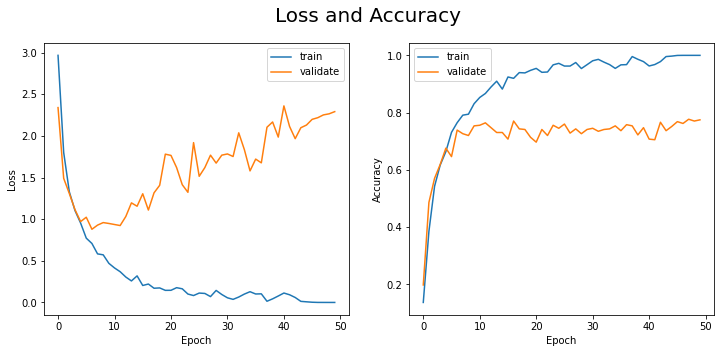

In [112]:
# Evaluating model performance
  # Accuracy on the validation data
print('')
print('Model Performance on Validation dataset = ', model1.evaluate(X_val, y_val_encoded, verbose=0)[1])
print()
  # Plot the loss and accuracy with epochs
plot_loss_accuracy(history1)

#------------------------------------------------#
                           precision    recall  f1-score   support

              Black-grass       0.54      0.54      0.54        26
                 Charlock       0.89      0.87      0.88        39
                 Cleavers       0.81      0.86      0.83        29
         Common Chickweed       0.93      0.90      0.92        61
             Common wheat       0.55      0.55      0.55        22
                  Fat Hen       0.81      0.74      0.78        47
         Loose Silky-bent       0.76      0.82      0.79        66
                    Maize       0.64      0.64      0.64        22
        Scentless Mayweed       0.72      0.79      0.75        52
          Shepherds Purse       0.80      0.70      0.74        23
Small-flowered Cranesbill       0.89      0.84      0.87        50
               Sugar beet       0.67      0.68      0.68        38

                 accuracy                           0.77       475
         

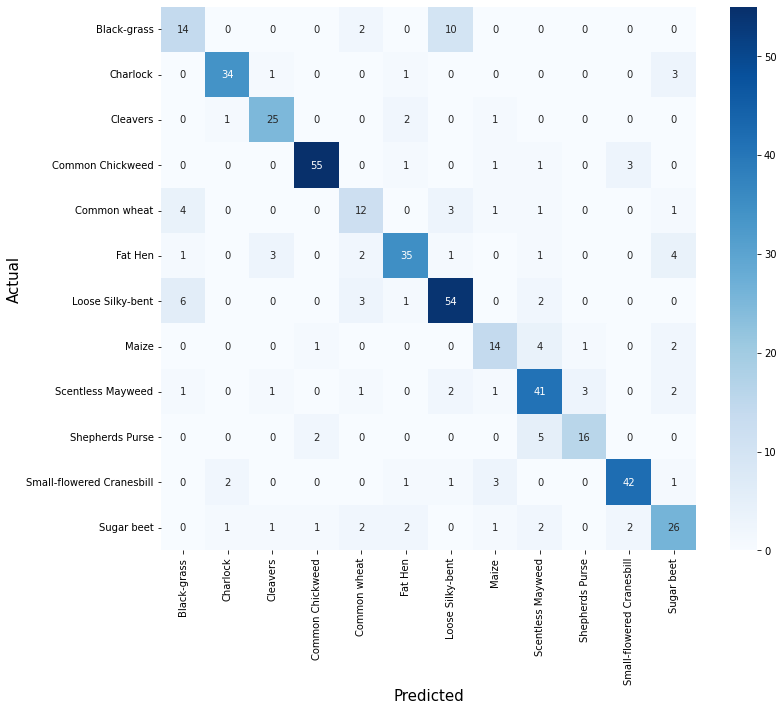

In [109]:
## Show the classification metrics and confusion matrix
f, ax = plt.subplots(figsize=(12,10))
make_confusion_matrix(model1,X_val, y_val_encoded, ax )

- The model used in this trial is a simpler model 
- The model overfits after approximately 5 epochs
- We will next try a similar neural network with dropout and batch normalization and see if we see any improvement in model performance

- ### **Model 2**

As we can see, our initial model appears to overfit. Therefore we'll try to address this problem with data augmentation, Dropout and Batch Normalization to check if we can improve the model's performance.

- #### **Data Augmentation**

In [113]:
# Create a data augmentor for training data
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   fill_mode='nearest',                                  
                                   horizontal_flip = True,
                                   vertical_flip = True)

In [115]:
# Clear the backend
clear_backend()

# Initializing the ANN
model2 = Sequential([Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)),
                     MaxPooling2D((2, 2), padding = 'same'),
                     Conv2D(64, (3, 3), activation='relu', padding="same"),
                     MaxPooling2D((2, 2), padding = 'same'),
                     BatchNormalization(),
                     Conv2D(64, (3, 3), activation='relu', padding="same"),
                     MaxPooling2D((2, 2), padding = 'same'),
                     BatchNormalization(),
                     Flatten(),
                     Dense(32, activation='relu'),
                     Dropout(0.3),
                     Dense(16, activation='relu'),
                     Dropout(0.2),
                     Dense(y_train_encoded.shape[1], activation = 'softmax')])

# Summarize the model
model2.summary()

# Compile and execute the model
  # Specify the optimizer
optimizer = Adam(learning_rate=0.001)
  # Compile the model and specify the loss function
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  # Specify the early stopping criteria
es_cb = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)
  # Save model when the val_accuracy is the highest
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  # Fitting the model
history2 = model2.fit(train_datagen.flow(X_train, y_train_encoded,
                                         batch_size=64, 
                                         seed=42,
                                         shuffle=True),
                      validation_data=(X_val, y_val_encoded), 
                      steps_per_epoch=X_train.shape[0] // 64,
                      epochs=50, 
                      verbose=1, 
                      callbacks=mc)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                        

- #### **Evaluate Model 2 performance**


Model Performance on Validation dataset =  0.8336842060089111



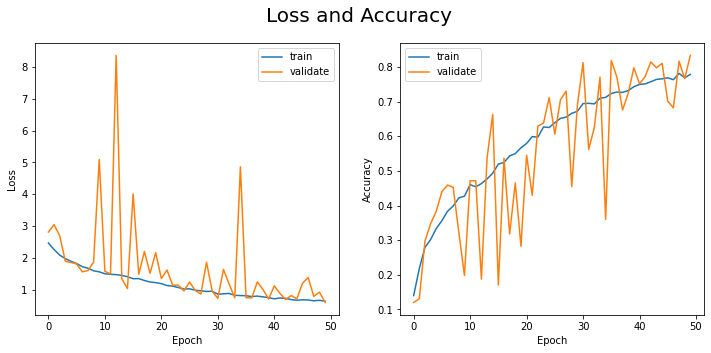

In [116]:
# Evaluating model performance
  # Accuracy on the validation data
print('')
print('Model Performance on Validation dataset = ', model2.evaluate(X_val, y_val_encoded, verbose=0)[1])
print()
  # Plot the loss and accuracy with epochs
plot_loss_accuracy(history2)

#------------------------------------------------#
                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        26
                 Charlock       0.97      0.97      0.97        39
                 Cleavers       1.00      0.83      0.91        29
         Common Chickweed       0.91      0.97      0.94        61
             Common wheat       0.94      0.73      0.82        22
                  Fat Hen       0.93      0.89      0.91        47
         Loose Silky-bent       0.66      1.00      0.80        66
                    Maize       0.78      0.64      0.70        22
        Scentless Mayweed       0.72      0.85      0.78        52
          Shepherds Purse       0.75      0.52      0.62        23
Small-flowered Cranesbill       0.96      0.96      0.96        50
               Sugar beet       0.82      0.87      0.85        38

                 accuracy                           0.83       475
         

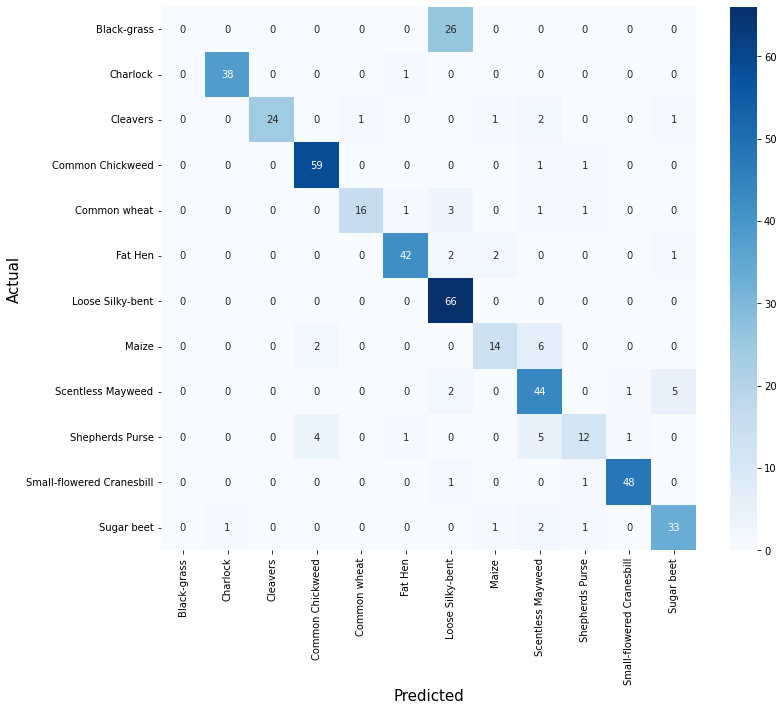

In [117]:
## Show the classification metrics and confusion matrix
f, ax = plt.subplots(figsize=(12,10))
make_confusion_matrix(model2,X_val, y_val_encoded, ax )

- The CNN with dropout, batch normalization and data augmentation is performing overall better than the previous model
  - The Black-grass is getting completely classified as Loose Silky-bent, which due to the similarity in the leaf pattern and the size
  

- ### **Model 3**

- Transfer Learning using VGG16
  - For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.


In [118]:
# Clear the backend
clear_backend()

## Load the VGG16 model
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))

# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

# # Summarize the model structure
# vgg_model.summary()

# Initializing the CNN
model3 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model3.add(Flatten())

# Adding a dense output layer
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(16, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(y_train_encoded.shape[1], activation = 'softmax'))

# Summarize the model
model3.summary()

# Compile and execute the model
  # Specify the optimizer
optimizer = Adam(learning_rate=0.001)
  # Compile the model and specify the loss function
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  # Specify the early stopping criteria
es_cb = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
  # Save model when the val_accuracy is the highest
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  # Fitting the model
history3 = model3.fit(train_datagen.flow(X_train, y_train_encoded,
                                         batch_size=64, 
                                         seed=42,
                                         shuffle=True),
                      validation_data=(X_val, y_val_encoded), 
                      steps_per_epoch=X_train.shape[0] // 64,
                      epochs=100, 
                      verbose=1, 
                      callbacks=mc)

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                         

- #### Evaluate Model 3 performance


Model Performance on Validation dataset =  0.5747368335723877



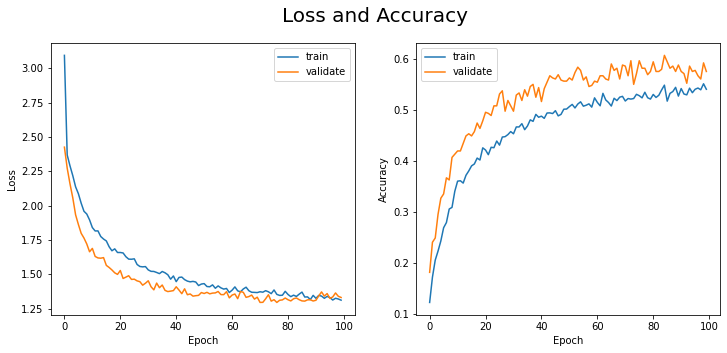

In [120]:
# Evaluating model performance
  # Accuracy on the validation data
print('')
print('Model Performance on Validation dataset = ', model3.evaluate(X_val, y_val_encoded, verbose=0)[1])
print()
  # Plot the loss and accuracy with epochs
plot_loss_accuracy(history3)

#------------------------------------------------#
                           precision    recall  f1-score   support

              Black-grass       0.50      0.27      0.35        26
                 Charlock       0.73      0.77      0.75        39
                 Cleavers       0.67      0.48      0.56        29
         Common Chickweed       0.77      0.66      0.71        61
             Common wheat       0.43      0.14      0.21        22
                  Fat Hen       0.45      0.30      0.36        47
         Loose Silky-bent       0.57      0.79      0.66        66
                    Maize       0.82      0.82      0.82        22
        Scentless Mayweed       0.54      0.63      0.58        52
          Shepherds Purse       0.00      0.00      0.00        23
Small-flowered Cranesbill       0.49      0.78      0.60        50
               Sugar beet       0.42      0.61      0.49        38

                 accuracy                           0.57       475
         

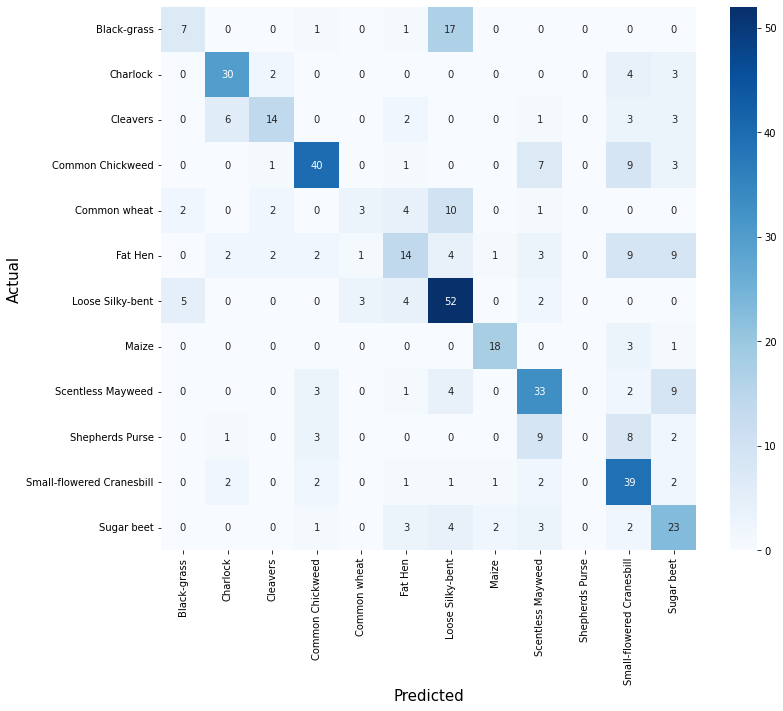

In [121]:
## Show the classification metrics and confusion matrix
f, ax = plt.subplots(figsize=(12,10))
make_confusion_matrix(model3,X_val, y_val_encoded, ax )

- VGG16 struggled to perform well on this dataset
  - This indicates that the pre trained CNN does not have feature identification capability for the current dataset
- We will try another pretrained CNN called ResNet50

- ### **Model 4**

- Transfer Learning using Resnet50
  - For training Resnet50, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.


In [123]:
# Clear the backend
clear_backend()

## Load the VGG16 model
resnet50_model = ResNet50(weights='imagenet', include_top = False, input_shape = (64,64,3))

# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in resnet50_model.layers:
    layer.trainable = False

# # Summarize the model structure
# resnet50v2_model.summary()

# Initializing the CNN
model4 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model4.add(resnet50_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model4.add(Flatten())

# Adding a dense output layer
model4.add(Dense(32, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(16, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(y_train_encoded.shape[1], activation = 'softmax'))

# Summarize the model
model4.summary()

# Compile and execute the model
  # Specify the optimizer
optimizer = Adam(learning_rate=0.001)
  # Compile the model and specify the loss function
model4.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  # Specify the early stopping criteria
es_cb = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)
  # Save model when the val_accuracy is the highest
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  # Fitting the model
history4 = model4.fit(train_datagen.flow(X_train, y_train_encoded,
                                         batch_size=64, 
                                         seed=42,
                                         shuffle=True),
                      validation_data=(X_val, y_val_encoded), 
                      steps_per_epoch=X_train.shape[0] // 64,
                      epochs=100, 
                      verbose=1, 
                      callbacks=mc)

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                         

- #### Evaluate Model 4 performance


Model Performance on Validation dataset =  0.6673684120178223



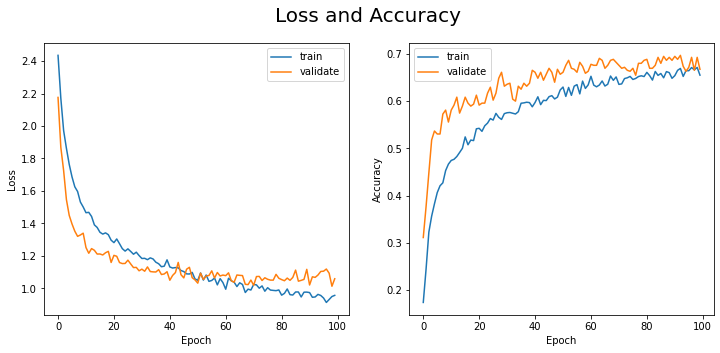

In [124]:
# Evaluating model performance
  # Accuracy on the validation data
print('')
print('Model Performance on Validation dataset = ', model4.evaluate(X_val, y_val_encoded, verbose=0)[1])
print()
  # Plot the loss and accuracy with epochs
plot_loss_accuracy(history4)

#------------------------------------------------#
                           precision    recall  f1-score   support

              Black-grass       0.48      0.46      0.47        26
                 Charlock       0.69      0.85      0.76        39
                 Cleavers       0.58      0.76      0.66        29
         Common Chickweed       0.84      0.77      0.80        61
             Common wheat       0.46      0.27      0.34        22
                  Fat Hen       0.65      0.47      0.54        47
         Loose Silky-bent       0.67      0.73      0.70        66
                    Maize       1.00      0.77      0.87        22
        Scentless Mayweed       0.66      0.73      0.69        52
          Shepherds Purse       0.50      0.13      0.21        23
Small-flowered Cranesbill       0.70      0.84      0.76        50
               Sugar beet       0.56      0.71      0.63        38

                 accuracy                           0.67       475
         

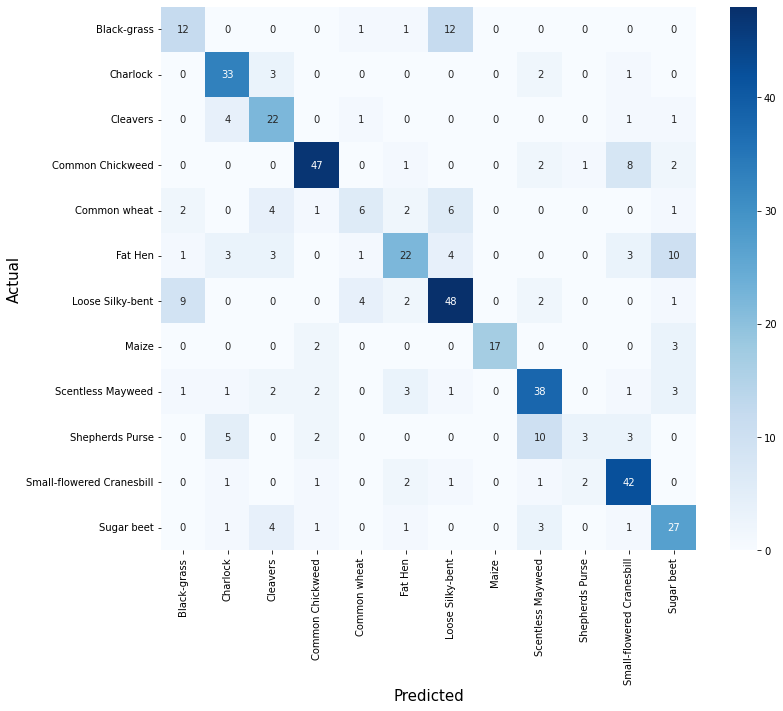

In [125]:
## Show the classification metrics and confusion matrix
f, ax = plt.subplots(figsize=(12,10))
make_confusion_matrix(model4,X_val, y_val_encoded, ax )

- ResNet50 did slightly better than VGG16 but still not at the level of model # 2
  - This indicates that feature identification required to detect the leaves is not present in the pre trained CNN and has to be developed from scratch

- ### **Models performance on Test dataset**

- #### We will evaluate model performance on test data using all the 4 models we have created

In [126]:
print('')
print('Model # 1 Performance on Test dataset = ', model1.evaluate(X_test, y_test_encoded, verbose=0)[1])
print()

print('')
print('Model # 2 Performance on Test dataset = ', model2.evaluate(X_test, y_test_encoded, verbose=0)[1])
print()

print('')
print('Model # 3 Performance on Test dataset = ', model3.evaluate(X_test, y_test_encoded, verbose=0)[1])
print()

print('')
print('Model # 4 Performance on Test dataset = ', model4.evaluate(X_test, y_test_encoded, verbose=0)[1])
print()


Model # 1 Performance on Test dataset =  0.7789473533630371


Model # 2 Performance on Test dataset =  0.8589473962783813


Model # 3 Performance on Test dataset =  0.551578938961029


Model # 4 Performance on Test dataset =  0.6989473700523376



- #### We will now show the confusion matrix using each model and test dataset

%%%%%%%%%%%%%%%%%%%% Performance of Model # 1 on test data %%%%%%%%%%%%%%%%% 

Model # 1 Performance on Test dataset =  0.7789473533630371

#------------------------------------------------#
                           precision    recall  f1-score   support

              Black-grass       0.40      0.30      0.34        27
                 Charlock       0.80      0.92      0.86        39
                 Cleavers       0.77      0.83      0.80        29
         Common Chickweed       0.91      0.87      0.89        61
             Common wheat       0.79      0.68      0.73        22
                  Fat Hen       0.83      0.79      0.81        48
         Loose Silky-bent       0.69      0.82      0.75        65
                    Maize       0.83      0.86      0.84        22
        Scentless Mayweed       0.73      0.73      0.73        51
          Shepherds Purse       0.70      0.61      0.65        23
Small-flowered Cranesbill       0.91      0.86      0.88        49
    

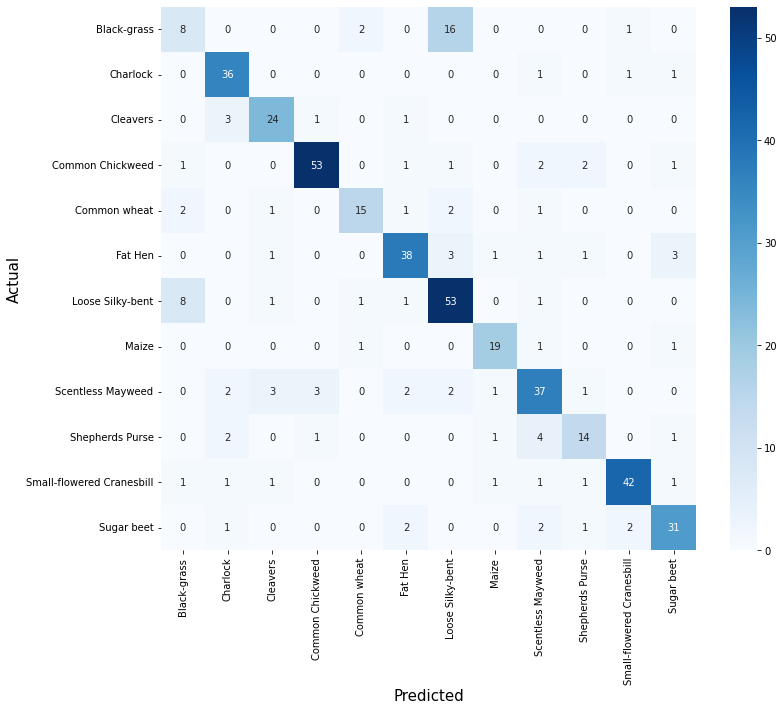

In [140]:
#### MODEL # 1 ####

## Show the classification metrics and confusion matrix
print('%%%%%%%%%%%%%%%%%%%% Performance of Model # 1 on test data %%%%%%%%%%%%%%%%% \n')
print('Model # 1 Performance on Test dataset = ', model1.evaluate(X_test, y_test_encoded, verbose=0)[1])
print()
f, ax = plt.subplots(figsize=(12,10))
make_confusion_matrix(model1,X_test, y_test_encoded, ax )

%%%%%%%%%%%%%%%%%%%% Performance of Model # 2 on test data %%%%%%%%%%%%%%%%% 

Model # 2 Performance on Test dataset =  0.8589473962783813

#------------------------------------------------#
                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        27
                 Charlock       0.88      0.95      0.91        39
                 Cleavers       0.81      0.76      0.79        29
         Common Chickweed       0.97      0.95      0.96        61
             Common wheat       0.90      0.86      0.88        22
                  Fat Hen       0.96      0.92      0.94        48
         Loose Silky-bent       0.68      0.97      0.80        65
                    Maize       0.88      0.95      0.91        22
        Scentless Mayweed       0.78      0.88      0.83        51
          Shepherds Purse       0.89      0.74      0.81        23
Small-flowered Cranesbill       0.96      0.94      0.95        49
    

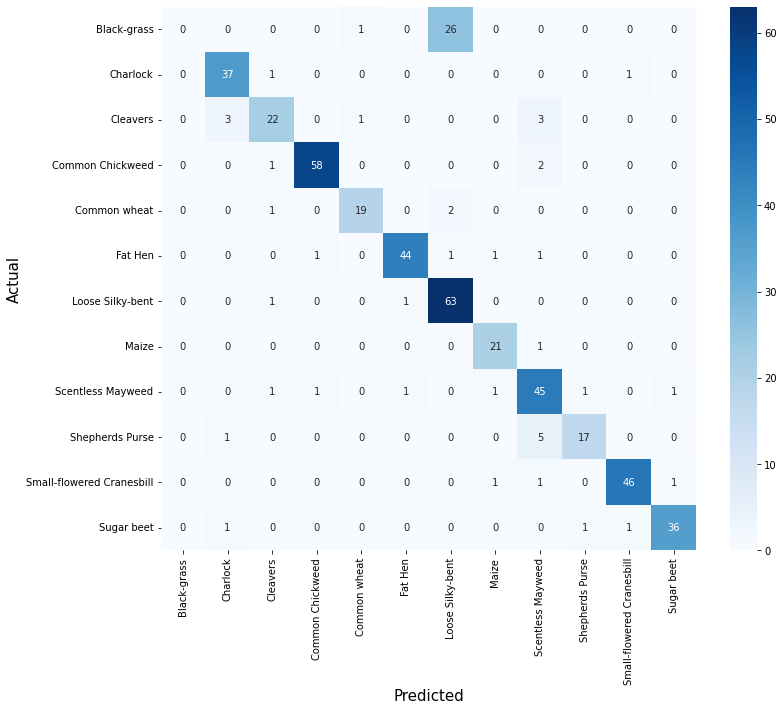

In [142]:
#### MODEL # 2 ####

## Show the classification metrics and confusion matrix
print('%%%%%%%%%%%%%%%%%%%% Performance of Model # 2 on test data %%%%%%%%%%%%%%%%% \n')
print('Model # 2 Performance on Test dataset = ', model2.evaluate(X_test, y_test_encoded, verbose=0)[1])
print()
f, ax = plt.subplots(figsize=(12,10))
make_confusion_matrix(model2,X_test, y_test_encoded, ax )

%%%%%%%%%%%%%%%%%%%% Performance of Model # 3 on test data %%%%%%%%%%%%%%%%% 

Model # 3 Performance on Test dataset =  0.551578938961029

#------------------------------------------------#
                           precision    recall  f1-score   support

              Black-grass       0.31      0.15      0.20        27
                 Charlock       0.57      0.62      0.59        39
                 Cleavers       0.52      0.38      0.44        29
         Common Chickweed       0.80      0.67      0.73        61
             Common wheat       0.82      0.41      0.55        22
                  Fat Hen       0.45      0.31      0.37        48
         Loose Silky-bent       0.55      0.77      0.64        65
                    Maize       0.77      0.91      0.83        22
        Scentless Mayweed       0.58      0.67      0.62        51
          Shepherds Purse       1.00      0.04      0.08        23
Small-flowered Cranesbill       0.45      0.59      0.51        49
     

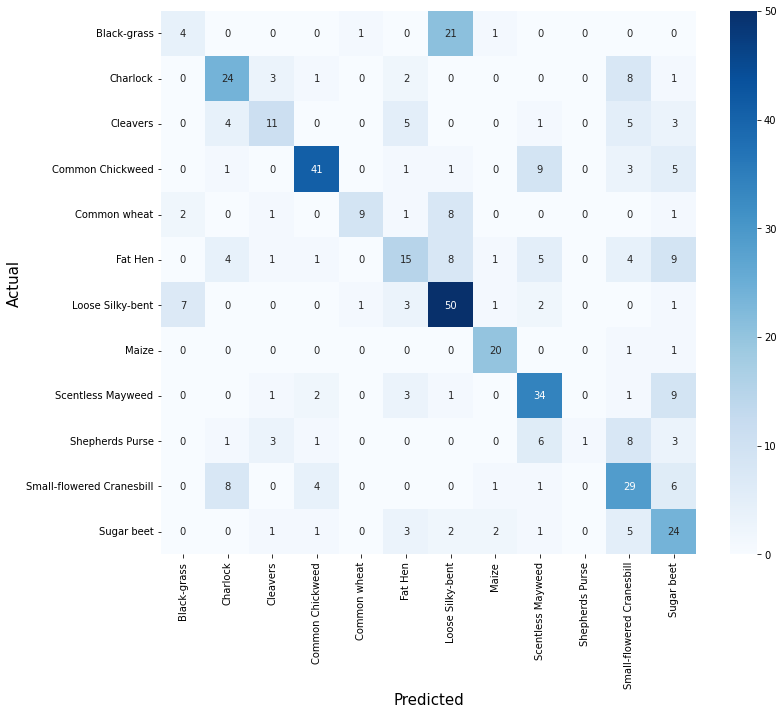

In [143]:
#### MODEL # 3 ####

## Show the classification metrics and confusion matrix
print('%%%%%%%%%%%%%%%%%%%% Performance of Model # 3 on test data %%%%%%%%%%%%%%%%% \n')
print('Model # 3 Performance on Test dataset = ', model3.evaluate(X_test, y_test_encoded, verbose=0)[1])
print()
f, ax = plt.subplots(figsize=(12,10))
make_confusion_matrix(model3,X_test, y_test_encoded, ax )

%%%%%%%%%%%%%%%%%%%% Performance of Model # 4 on test data %%%%%%%%%%%%%%%%% 


Model # 4 Performance on Test dataset =  0.6989473700523376

#------------------------------------------------#
                           precision    recall  f1-score   support

              Black-grass       0.45      0.33      0.38        27
                 Charlock       0.68      0.77      0.72        39
                 Cleavers       0.62      0.79      0.70        29
         Common Chickweed       0.94      0.74      0.83        61
             Common wheat       0.67      0.45      0.54        22
                  Fat Hen       0.64      0.58      0.61        48
         Loose Silky-bent       0.71      0.78      0.74        65
                    Maize       0.86      0.86      0.86        22
        Scentless Mayweed       0.64      0.92      0.75        51
          Shepherds Purse       0.75      0.13      0.22        23
Small-flowered Cranesbill       0.70      0.78      0.74        49
   

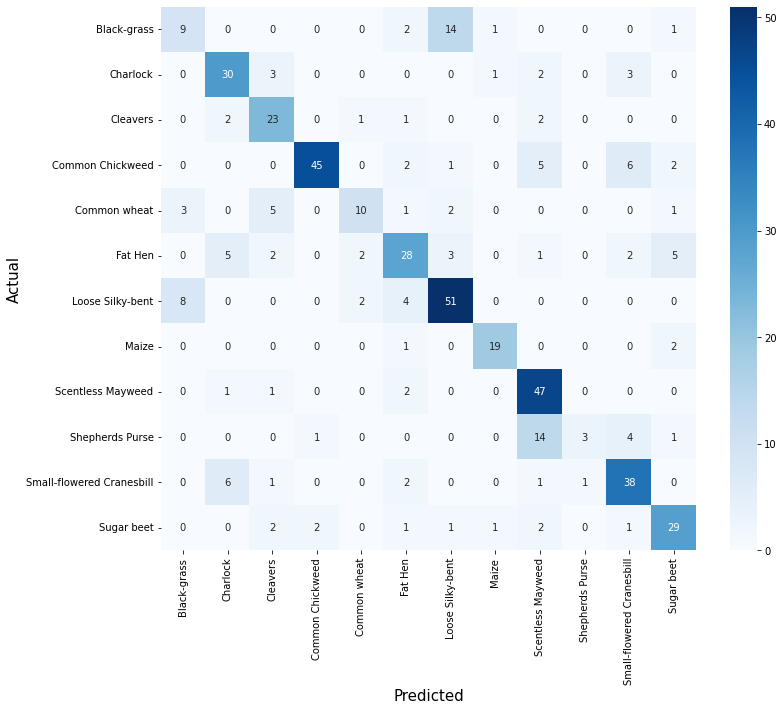

In [144]:
#### MODEL # 4 ####

## Show the classification metrics and confusion matrix
print('%%%%%%%%%%%%%%%%%%%% Performance of Model # 4 on test data %%%%%%%%%%%%%%%%% \n\n')
print('Model # 4 Performance on Test dataset = ', model4.evaluate(X_test, y_test_encoded, verbose=0)[1])
print()
f, ax = plt.subplots(figsize=(12,10))
make_confusion_matrix(model4,X_test, y_test_encoded, ax )

- Based on the results of our models evaluated on test data, we can conclude that Model # 2 has the best performance.
- It does not ovefit and consistently the Model # 2 performance on train and validation data is very similar
- It fails to distinguish between Black-grass and Loose Silky-bent, due to unclear pictures and similarity between leaf design

## **Summary**

- We have analyzed an image dataset of 4750 images belonging to 12 different categories of seedlings
- The input images are of 128x128 RGB type
- We reduced the image size to 64x64 RGB to lower the computation time
- We checked our images for the impact of blur on them and more specifically the two species which have very thin leaves which are hard to recognize infront of the background.
  - The blurring did not help improve the image and its perception to human eye

- We build 4 models to classify images
  - Model # 1: 3 CNN layers + 2 FC layers
  - Model # 2: 3 CNN layers with batchnormalization + 2 FC with dropout
  - Model # 3: CNN layers of VGG16 + 2 FC layers
  - Model # 4: CNN layers of ResNet50 + 2 FC layers

- Out of all the 4 model, Model # 2 performed best in identifying the seedlings with 86% accuracy
  - The model still struggles with distinguishing between Black-grass and Loose Silky-bent due to very small leaves which look very similar

- The issue with distinguishing between Black-grass and Losse Silky-bent can be resolved by taking more closeup pictures against a more clear background